In [1]:
# standard packages
from os import listdir
from tqdm import tqdm
import os
import pickle
# data science stack packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge
# our implementation
from dataloader import DataLoader, FeatureLoader
from features import *
from selection import GridSearchWeightedCV
from selection import SelectKBestIC, SelectKBestWeightedR2
from pipeline import Winsorizer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# first read the data from raw dataset
if os.path.isfile('data/data.p') == True:
    data = pickle.load(open('data/data.p', 'rb'))
else:
    dataloader = DataLoader('train')
    data = dataloader.load_features(
        start_date='20140102', end_date='20171229', how='outer')
    pickle.dump(data, open('data/data.p', 'wb'))

In [3]:
class EDA:
    
    '''
    class to do the exploratory data analysis
    '''
    
    def __init__(self, df):
        self.df = df
        self.size = len(df)
        
    def bin_plot(self, x_label, y_label, n_bins, w_label=None, scale=1, ax=None, **plot_kwargs):
        
        '''
        create a bin plot with your feature (x_label), binned into (num_bin) quantiles 
        (with equal count), on the X-axis, and the corresponding mean of the target
        variable (y_label) along with one standard error around mean on the Y-axis. 
        
        Parameters
        ----------------
        x_label: str
            label of feature x
            
        y_label: str
            label of target
            
        w_label: str
            label of weight if provided
            
        scale: float, default=1
            where to plot the point with the bin = mean(bin) * scale
            
        ax: axes
            ax to plot on, if None, the function will create one
            
        n_bins: int
            number of bins
            
        **plot_kwargs: dict
            keyword and arguments of ax.plot(x, y)
        '''
        
        key = self.df[x_label].values
        value = self.df[y_label].values
        if w_label is not None:
            w = self.df[w_label].values
        
            
        sorted_idx = np.argsort(key)
        chunks = np.array_split(sorted_idx, n_bins)
              
        # x axis on the plot: bin mean
        x = np.ones(n_bins)
        # boundary of the bins
        b = np.ones(n_bins)
        # y axis on the plot: bin mean
        y = np.ones(n_bins)
        # confidence of y: bin std
        c = np.ones(n_bins)
        
        for bin_idx, idx in enumerate(chunks):
            
            x[bin_idx] = np.mean(key[idx]) * scale
            b[bin_idx] = np.max(key[idx])
            if w_label is not None:
                y[bin_idx] = np.average(value[idx], weights=w[idx])
            else:
                y[bin_idx] = np.mean(value[idx])
            c[bin_idx] = np.std(value[idx]) / np.sqrt(len(value[idx]))
        
        if ax is None: 
            fig, ax = plt.subplots(figsize=(10, 6))
            
        ymin = np.min(y-c) - 0.5 * abs(np.min(y-c))
        ymax = np.max(y+c) + 0.5 * abs(np.max(y-c))
            
        ax.plot(x, y, 'o-', **plot_kwargs)
        ax.fill_between(x, y-c, y+c, color='b', alpha=0.1)
        ax.vlines(b[:-1], ymin=ymin, ymax=ymax, color='grey')
        ax.set_xticks(b[:-1])
        ax.set_ylim(bottom=ymin, top=ymax)
        ax.set_xlabel('bin boundaries, based on quantiles of {:s}'.format(x_label))
        ax.set_ylabel('within-bin means and 1 std error of {:s}'.format(y_label))
        ax.set_title('{:d} binned plot of {:s} against {:s}'.format(n_bins, y_label, x_label))
        
        
    def scatter(self, x_label, y_label, ax=None, **plot_kwargs):
        
        '''
        plot the ordinary scatter plot
        
        Parameters
        ----------------
        x_label: str
            label of feature x
            
        y_label: str
            label of target
            
        ax: axes
            ax to plot on, if None, the function will create one
            
        **plot_kwargs: dict
            keyword and arguments of ax.scatter(x, y)
        
        '''
        
        x = self.df[x_label]
        y = self.df[y_label]
        
        if ax is None:
            
            fig, ax = plt.subplots(figsize=(10, 6))
            
        ax.scatter(x, y, **plot_kwargs)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title('Scatter plot of {:s} against {:s}'.format(y_label, x_label))
        
    def lowess_plot(self, x_label, y_label, ax=None, sample_size=1.0, frac=1./3, **plot_kwargs):
        
        '''
        
        plot the scatter plot with lowess plot and the zoomed window
        
        A continuous version of binned plot
        
        see https://en.wikipedia.org/wiki/Local_regression for detail of lowess
        
        Parameters
        ----------------
        x_label: str
            label of feature x
            
        y_label: str
            label of target
            
        ax: axes
            ax to plot on, if None, the function will create one
            
        frac: float, default=1./3
            fraction parameter of lowess
            
        **plot_kwargs: dict
            keyword and arguments of ax.scatter(x, y)
        '''
        
        df_xy = self.df[[x_label, y_label]].dropna(inplace=False).sample(frac=sample_size)
        
        x = df_xy[x_label].values
        y = df_xy[y_label].values
        
        model = sm.OLS(y,x)
        fitted = model.fit()
        w = fitted.predict(x)
        
        if ax is None: 
            fig, ax = plt.subplots(figsize=(8, 8))
  
        z = lowess(y, x, return_sorted=True, frac=frac)
        ax.scatter(x,y,color='tab:blue', label='scatter', **plot_kwargs)
        ax.plot(z[:,0],z[:,1],color='tab:red', label='lowess')
        ax.plot(x, w, ':', color='black', label='linear regression')
        ax.set_title('lowess of {:s} against {:s}: R$^2$ = {:.4f}%'.format(y_label, x_label, 100*fitted.rsquared))
        ax.legend()
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        axins = inset_axes(ax, width="30%", height=2., loc=2) 
        ymin = np.min(np.append(z[:,1],w))
        ymax = np.max(np.append(z[:,1],w))
        axins.set_ylim([ymin, ymax])
        axins.scatter(x,y,color='tab:blue', label='scatter', **plot_kwargs)
        axins.plot(z[:,0],z[:,1],color='tab:red', label='lowess')
        axins.plot(x, w, ':',color='black', label='linear regression')
        axins.set_xlabel('zoomed')
        # Turn off tick labels
        axins.set_yticklabels([])
        axins.set_xticklabels([])

In [4]:
class YesterdayRet(FeatureExtractor):
    
    def transform(self, date, save=True):
        
        ret = self.data['ResidualNoWinsorCumReturn_close'].loc[date]
        df_feature = ret.to_frame(name=self.feature_name)
        if save == True:
            self.save(df_feature, date)
        return df_feature
        
class TodaytoNextMorningRet(FeatureExtractor):
    
    def transform(self, date, save=True):
        date_idx = list(self.data['ResidualNoWinsorCumReturn_close'].index).index(date)
        ret_open = self.data['ResidualNoWinsorCumReturn_open'].iloc[date_idx+1]
        df_feature = ret_open.to_frame(name=self.feature_name)
        if save == True:
            self.save(df_feature, date)
        return df_feature
    
class NextIntradayRet(FeatureExtractor):
    
    def transform(self, date, save=True):
        date_idx = list(self.data['ResidualNoWinsorCumReturn_close'].index).index(date)
        ret_open = self.data['ResidualNoWinsorCumReturn_open'].iloc[date_idx+1]
        ret_close = self.data['ResidualNoWinsorCumReturn_close'].iloc[date_idx+1]
        ret = ret_close - ret_open
        df_feature = ret.to_frame(name=self.feature_name)
        if save == True:
            self.save(df_feature, date)
        return df_feature
    
feature_loader_ret = FeatureLoader(raw_dir='train', # the raw dataset 
                                   feature_dir='features_ret', # where to save the features
                                   target_dir='train/return', # your target directory
                                   data=data)
feature_loader_ret.register(YesterdayRet, name='prev_ret')
feature_loader_ret.register(TodaytoNextMorningRet, name='next_ret_1')
feature_loader_ret.register(NextIntradayRet, name='next_ret_2')
feature_loader_ret.register(InversedVol, name='1/estVol')
feature_loader_ret.extract(start_date='20170102', end_date='20171228')
df_rets = feature_loader_ret.load_features(start_date='20170102', end_date='20171228')
df_rets

,Id,prev_ret,next_ret_1,next_ret_2,1/estVol,ResidualNoWinsorCumReturn,Date
0,ID000BC0KZ7,-0.001522,-0.003152,-0.001775,9.536252,-0.004927,20170102
795,ID000BC0KZ7,-0.004927,-0.008382,0.018117,9.590946,0.009734,20170103
1590,ID000BC0KZ7,0.009734,-0.005536,-0.008089,8.694896,-0.013624,20170104
2384,ID000BC0KZ7,-0.013624,0.025417,0.001876,8.217535,0.027293,20170105
3176,ID000BC0KZ7,0.027293,-0.009189,-0.000082,7.973719,-0.009271,20170106
...,...,...,...,...,...,...,...
199519,IDZQ000ZTH2,0.002942,-0.013971,0.002186,5.702652,-0.011785,20171220
200314,IDZQ000ZTH2,-0.011785,0.004878,-0.010335,5.880969,-0.005457,20171221
201106,IDZQ000ZTH2,-0.005457,-0.001949,-0.007103,5.948062,-0.009052,20171222
201897,IDZQ000ZTH2,-0.009052,-0.001130,-0.004716,6.127601,-0.005846,20171227


In [5]:
y_pred = pickle.load(open('models/y_pred_xgb, 19 new features.pickle', 'rb'))['2017-01-01':]
df_rets['ret_pred'] = y_pred.values
df_rets

,Id,prev_ret,next_ret_1,next_ret_2,1/estVol,ResidualNoWinsorCumReturn,Date,ret_pred
0,ID000BC0KZ7,-0.001522,-0.003152,-0.001775,9.536252,-0.004927,20170102,0.000264
795,ID000BC0KZ7,-0.004927,-0.008382,0.018117,9.590946,0.009734,20170103,-0.000036
1590,ID000BC0KZ7,0.009734,-0.005536,-0.008089,8.694896,-0.013624,20170104,0.000053
2384,ID000BC0KZ7,-0.013624,0.025417,0.001876,8.217535,0.027293,20170105,0.000110
3176,ID000BC0KZ7,0.027293,-0.009189,-0.000082,7.973719,-0.009271,20170106,-0.000199
...,...,...,...,...,...,...,...,...
199519,IDZQ000ZTH2,0.002942,-0.013971,0.002186,5.702652,-0.011785,20171220,0.000101
200314,IDZQ000ZTH2,-0.011785,0.004878,-0.010335,5.880969,-0.005457,20171221,0.000181
201106,IDZQ000ZTH2,-0.005457,-0.001949,-0.007103,5.948062,-0.009052,20171222,0.000033
201897,IDZQ000ZTH2,-0.009052,-0.001130,-0.004716,6.127601,-0.005846,20171227,0.000084


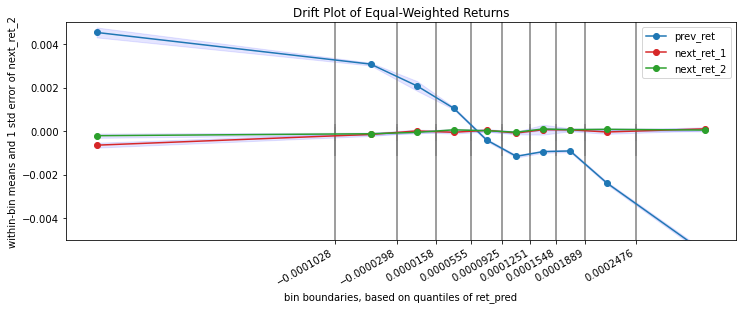

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
eda = EDA(df_rets)
eda.bin_plot(x_label='ret_pred', y_label='prev_ret', n_bins=10, ax=ax, label='prev_ret', color='tab:blue')
eda.bin_plot(x_label='ret_pred', y_label='next_ret_1', n_bins=10, ax=ax, label='next_ret_1', color='tab:red')
eda.bin_plot(x_label='ret_pred', y_label='next_ret_2', n_bins=10, ax=ax, label='next_ret_2', color='tab:green')
ax.set_ylim(bottom=-0.005, top=0.005)
ax.legend(loc='best')
ax.set_title('Drift Plot of Equal-Weighted Returns')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

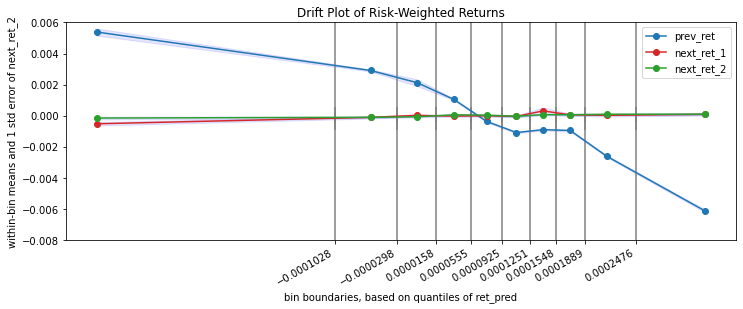

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
eda = EDA(df_rets)
eda.bin_plot(x_label='ret_pred', y_label='prev_ret', w_label='1/estVol', n_bins=10, ax=ax, label='prev_ret', color='tab:blue')
eda.bin_plot(x_label='ret_pred', y_label='next_ret_1', w_label='1/estVol',  n_bins=10, ax=ax, label='next_ret_1', color='tab:red')
eda.bin_plot(x_label='ret_pred', y_label='next_ret_2', w_label='1/estVol',  n_bins=10, ax=ax, label='next_ret_2', color='tab:green')
ax.set_ylim(bottom=-0.008, top=0.006)
ax.legend(loc='best')
ax.set_title('Drift Plot of Risk-Weighted Returns')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

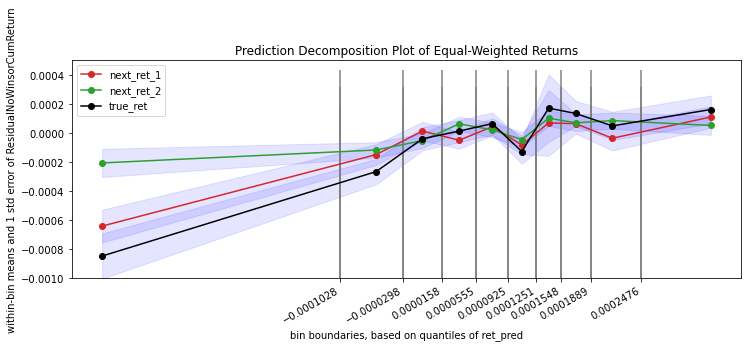

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
eda.bin_plot(x_label='ret_pred', y_label='next_ret_1', n_bins=10, ax=ax, label='next_ret_1', color='tab:red')
eda.bin_plot(x_label='ret_pred', y_label='next_ret_2', n_bins=10, ax=ax, label='next_ret_2', color='tab:green')
eda.bin_plot(x_label='ret_pred', y_label='ResidualNoWinsorCumReturn', n_bins=10, ax=ax, label='true_ret', color='black')
ax.set_ylim(bottom=-0.001, top=0.0005)
ax.legend(loc='best')
ax.set_title('Prediction Decomposition Plot of Equal-Weighted Returns')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right');

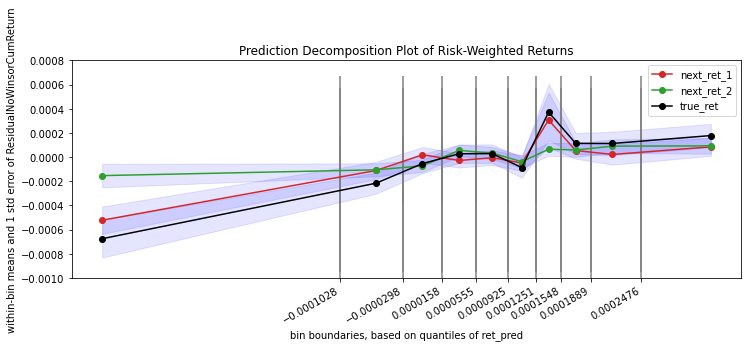

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
eda.bin_plot(x_label='ret_pred', y_label='next_ret_1', w_label='1/estVol', n_bins=10, ax=ax, label='next_ret_1', color='tab:red')
eda.bin_plot(x_label='ret_pred', y_label='next_ret_2', w_label='1/estVol', n_bins=10, ax=ax, label='next_ret_2', color='tab:green')
eda.bin_plot(x_label='ret_pred', y_label='ResidualNoWinsorCumReturn', w_label='1/estVol', n_bins=10, ax=ax, label='true_ret', color='black')
ax.set_ylim(bottom=-0.001, top=0.0008)
ax.legend(loc='best')
ax.set_title('Prediction Decomposition Plot of Risk-Weighted Returns')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right');